# PoseNet for Self-Localization Task on TUM Dataset

In [1]:
# Load all dependency
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torchviz
import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape
from datasets.tum import TUM

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params, quaternion_angular_error

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime
import random

%matplotlib inline
plt.ion()


In [2]:
APOLLO_PATH = "/home/sufferlinux/Downloads/derbyml"
# APOLLO_PATH = "/home/hsuan/Desktop"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
#     transforms.Resize((224, 672)),
    transforms.ToTensor(),
    normalize
])

# 4/23	Train	1,2,3,4,6,7,8,10,11
# 	Test	9,12,13,15	

pretrained = True
stereo = False
shuffle = True

batch_size = 10

checkpoint_file = 'model/Trained_ResNet50.tar'

train_set = ['sequence_01', 'sequence_03', 'sequence_06', 'sequence_07', 'sequence_08', 'sequence_09',
               'sequence_10', 'sequence_12', 'sequence_14', 'sequence_15']


train_list = [ TUM(root=os.path.join(APOLLO_PATH), road="TUM",
                             transform=transform, record=k, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True, stereo=stereo)\
                             for k in train_set]


experiment_name = "NF_50_V2_1113"
val_record = "sequence_02"
val_dataset = TUM(root=os.path.join(APOLLO_PATH), road="TUM",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True, stereo=stereo)


test_set = ['sequence_02', 'sequence_11', 'sequence_13']
test_list = [ TUM(root=os.path.join(APOLLO_PATH), road="TUM",
                             transform=transform, record=k, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True, stereo=stereo)\
                             for k in test_set]


print(val_dataset)


train_dataloader_list = [ DataLoader(i, batch_size=batch_size, shuffle=shuffle, num_workers=2) 
                          for i in train_list]
test_dataloader_list = [ DataLoader(i, batch_size=batch_size, shuffle=shuffle, num_workers=2) 
                          for i in test_list]
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)



pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
Dataset: TUM
    Road: TUM
    Record: sequence_02
    Train: False
    Normalize Poses: True
    Stereo: False
    Length: 1592 of 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create pretrained feature extractor
# feature_extractor = models.resnet18(pretrained=True)
feature_extractor = models.resnet34(pretrained=True)
# feature_extractor = models.resnet50(pretrained=True)
# feature_extractor = models.resnet101(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = PoseNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)

# Criterion
# criterion = PoseNetCriterion(stereo=stereo, beta=500.0)
criterion = PoseNetCriterion(stereo=False, learn_beta=True)
criterion = criterion.to(device)

# Add all params for optimization
param_list = [{'params': model.parameters()}]
if criterion.learn_beta:
    param_list.append({'params': criterion.parameters()})

# Create optimizer
optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)

start_epoch = 0


In [4]:
#Restore from checkpoint
# checkpoint_file = '_checkpoints/20180823_085404_zpark_posenet_L1_resnet34p_2048_e2880.pth.tar'
# checkpoint_file = 'val_02_20200422_083030_nb_T03_e3000.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']
        print ('epochs', start_epoch)
        if 'criterion_state_dict' in checkpoint:
            criterion.load_state_dict(checkpoint['criterion_state_dict'])
            print('Loaded criterion params.')
            



Loading from checkpoint: _checkpoints/20200425_071132_nb_NF_34_V2_1113_e3000.pth.tar
epochs 3000
Loaded criterion params.


In [5]:
def model_results_pred_gt(model, dataloader, poses_mean, poses_std, stereo=True):
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_poses) in enumerate(dataloader):
        
        if stereo:
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
        else:
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)


        out = model(batch_images)
        
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        # move data to cpu & numpy
        if stereo:
            batch_poses = [x.detach().cpu().numpy() for x in batch_poses]
            out = [x.detach().cpu().numpy() for x in out]
            gt_poses = np.vstack((gt_poses, *batch_poses))
            pred_poses = np.vstack((pred_poses, *out))
        else:
            bp = batch_poses.detach().cpu().numpy()
            outp = out.detach().cpu().numpy()
            gt_poses = np.vstack((gt_poses, bp))
            pred_poses = np.vstack((pred_poses, outp))


        
    # un-normalize translation
    gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
    pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    return pred_poses, gt_poses



In [6]:
def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    plt.legend(['Pred_Pose','GT_Pose'])
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()


# Plot Testing Dataset

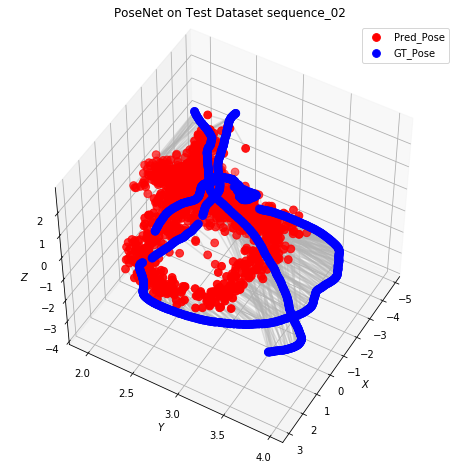

gt_poses = (1592, 7)
pred_poses = (1592, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.976, mean = 1.266
R: median = 10.096, mean = 13.213
--------------end--------------


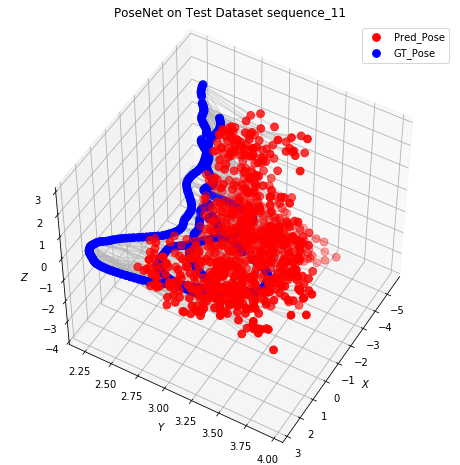

gt_poses = (914, 7)
pred_poses = (914, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.959, mean = 1.037
R: median = 19.578, mean = 32.862
--------------end--------------


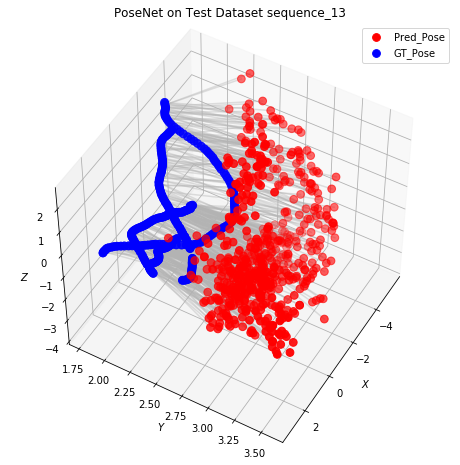

gt_poses = (582, 7)
pred_poses = (582, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 1.233, mean = 1.280
R: median = 7.981, mean = 9.140
--------------end--------------


In [7]:
pred_test = [ model_results_pred_gt(model, k, k.dataset.poses_mean, k.dataset.poses_std, stereo=stereo) \
                                                      for k in test_dataloader_list]
for i, pred in enumerate(pred_test):
    draw_pred_gt_poses(pred[0], pred[1])
    title = 'PoseNet on Test Dataset ' + test_set[i]
    plt.title(title)
    plt.show()
    pred_poses, gt_poses = pred[0], pred[1]
    print('gt_poses = {}'.format(gt_poses.shape))
    print('pred_poses = {}'.format(pred_poses.shape))
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
    print('Translation(T) error in meters and Rotation(R) error in degrees:')
    print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
    print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))
    print('--------------end--------------')

# Plot Training Dataset

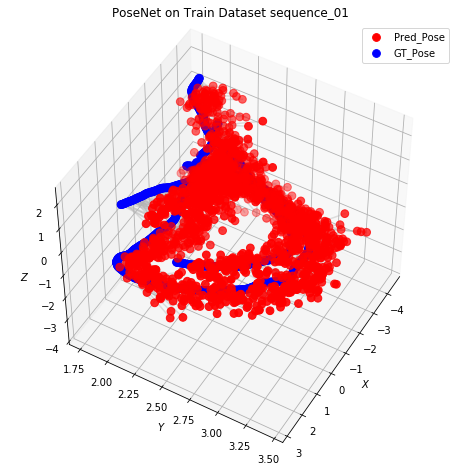

gt_poses = (1936, 7)
pred_poses = (1936, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.341, mean = 0.378
R: median = 6.101, mean = 6.273
--------------end--------------


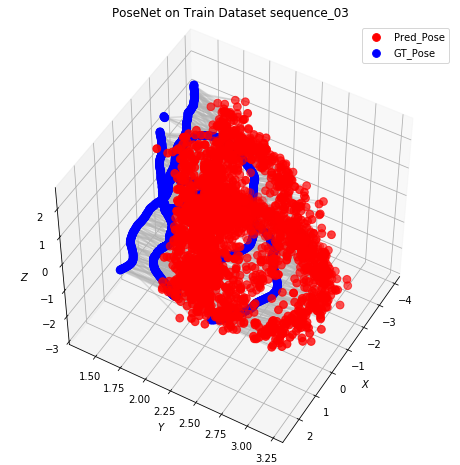

gt_poses = (2818, 7)
pred_poses = (2818, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.505, mean = 0.527
R: median = 8.306, mean = 8.991
--------------end--------------


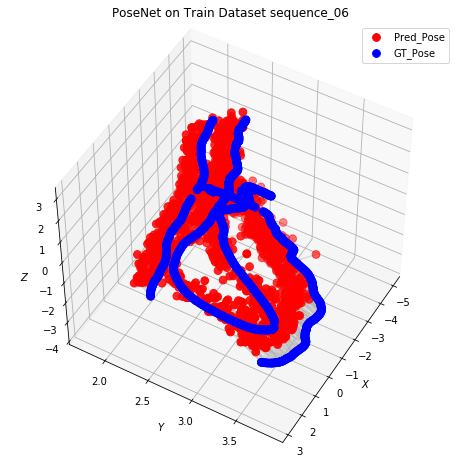

gt_poses = (1864, 7)
pred_poses = (1864, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.408, mean = 0.438
R: median = 5.276, mean = 5.696
--------------end--------------


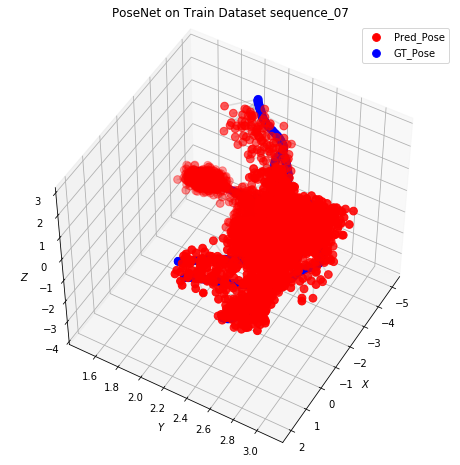

gt_poses = (2766, 7)
pred_poses = (2766, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.332, mean = 0.376
R: median = 8.488, mean = 8.873
--------------end--------------


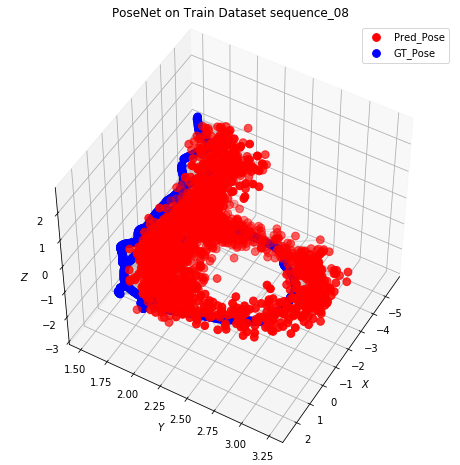

gt_poses = (1990, 7)
pred_poses = (1990, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.424, mean = 0.490
R: median = 5.354, mean = 6.063
--------------end--------------


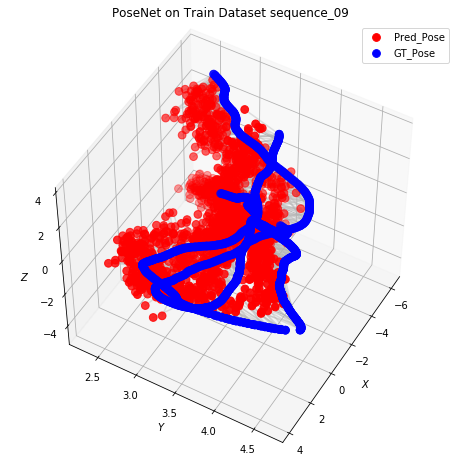

gt_poses = (1926, 7)
pred_poses = (1926, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.651, mean = 0.726
R: median = 6.660, mean = 7.235
--------------end--------------


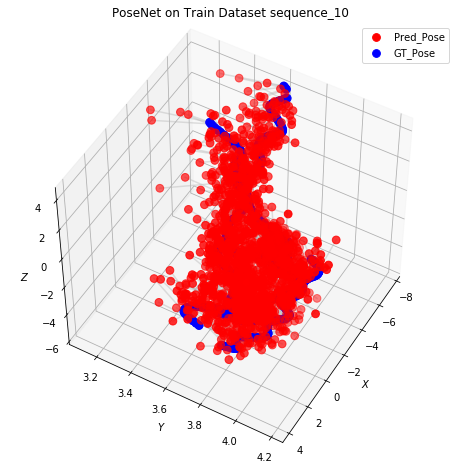

gt_poses = (1590, 7)
pred_poses = (1590, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.735, mean = 0.772
R: median = 8.406, mean = 9.967
--------------end--------------


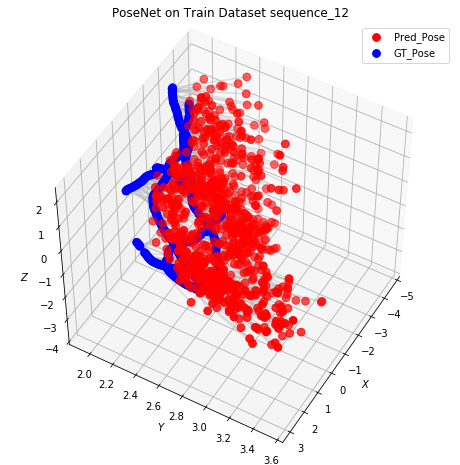

gt_poses = (870, 7)
pred_poses = (870, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.612, mean = 0.650
R: median = 5.186, mean = 5.428
--------------end--------------


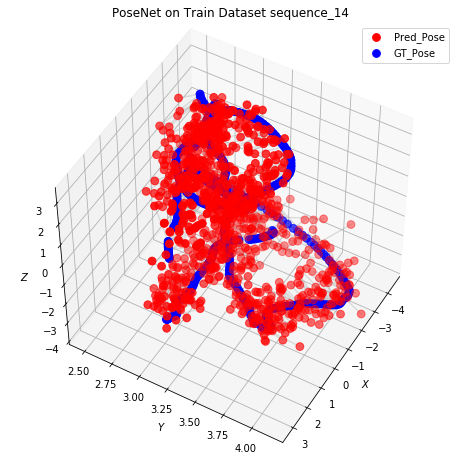

gt_poses = (1028, 7)
pred_poses = (1028, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.476, mean = 0.510
R: median = 3.473, mean = 4.162
--------------end--------------


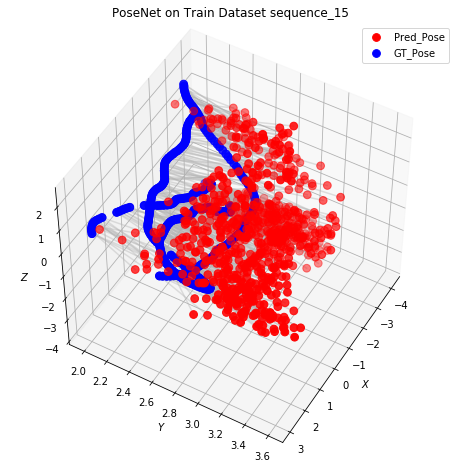

gt_poses = (802, 7)
pred_poses = (802, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.742, mean = 0.784
R: median = 5.616, mean = 6.692
--------------end--------------


In [8]:
pred_train = [ model_results_pred_gt(model, k, k.dataset.poses_mean, k.dataset.poses_std, stereo=stereo) \
                                                      for k in train_dataloader_list]
for i, pred in enumerate(pred_train):
    draw_pred_gt_poses(pred[0], pred[1])
    title = 'PoseNet on Train Dataset ' + train_set[i]
    plt.title(title)
    plt.show()
    pred_poses, gt_poses = pred[0], pred[1]
    print('gt_poses = {}'.format(gt_poses.shape))
    print('pred_poses = {}'.format(pred_poses.shape))
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
    print('Translation(T) error in meters and Rotation(R) error in degrees:')
    print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
    print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))
    print('--------------end--------------')